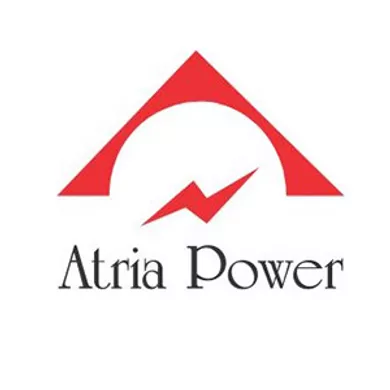

# ***Improving Solar Production***

### ***A project by Piyush Tripathi and Astitva Prakash, under the mentorship of Azib Hasan*** 

# **Objectives**

* ### Better understanding and prediction of production of renewable energy
* ### Improved accuracy and lead time for detection of degradation and diagnosis of failures
* ### Making these new analytics and the associated data readily accessible to end users and to internal customers who are not data science experts themselves

# **Prerequisites**

## **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import fbprophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import datetime
import os

## **Importing Datasets**

In [ ]:
df_pg1 = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
df_pg2 = pd.read_csv('../input/solar-power-generation-data/Plant_2_Generation_Data.csv')
df_ws1 = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
df_ws2 = pd.read_csv('../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [ ]:
#Plant 1
df_pgen1=pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
df_sen1=pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')

# **Cleaning Data**

## **Examining Dataframes**

In [ ]:
df_pgen1

In [ ]:
df_sen1

## **Optimizing the DataFrame**

In [ ]:
# Power Generation Plant 1

df_pgen1['DATE_TIME'] = pd.to_datetime(df_pgen1['DATE_TIME'],format = '%d-%m-%Y %H:%M')
df_pgen1['DATE'] = df_pgen1['DATE_TIME'].apply(lambda x:x.date())
df_pgen1['TIME'] = df_pgen1['DATE_TIME'].apply(lambda x:x.time())
df_pgen1['DATE'] = pd.to_datetime(df_pgen1['DATE'],format = '%Y-%m-%d')
df_pgen1['HOUR'] = pd.to_datetime(df_pgen1['TIME'],format='%H:%M:%S').dt.hour
df_pgen1['MINUTES'] = pd.to_datetime(df_pgen1['TIME'],format='%H:%M:%S').dt.minute
df_pgen1['DC_POWER'] = df_pgen1[['DC_POWER']].apply(lambda arr: np.divide(arr,10))

In [ ]:
# Weather Sensor Data 1

df_sen1['DATE_TIME'] = pd.to_datetime(df_sen1['DATE_TIME'],format = '%Y-%m-%d %H:%M')
df_sen1['DATE'] = df_sen1['DATE_TIME'].apply(lambda x:x.date())
df_sen1['TIME'] = df_sen1['DATE_TIME'].apply(lambda x:x.time())
df_sen1['DATE'] = pd.to_datetime(df_sen1['DATE'],format = '%Y-%m-%d')
df_sen1['HOUR'] = pd.to_datetime(df_sen1['TIME'],format='%H:%M:%S').dt.hour
df_sen1['MINUTES'] = pd.to_datetime(df_sen1['TIME'],format='%H:%M:%S').dt.minute

In [ ]:
# Data Preprocessing
## Here we make the DATE_TIME column (which right now contains string values) datetimeobjects
df_pg1['DATE_TIME'] = pd.to_datetime(df_pg1['DATE_TIME'], format = '%d-%m-%Y %H:%M')
df_pg2['DATE_TIME'] = pd.to_datetime(df_pg2['DATE_TIME'], format = '%Y-%m-%d %H:%M')
df_ws1['DATE_TIME'] = pd.to_datetime(df_ws1['DATE_TIME'], format = '%Y-%m-%d %H:%M')
df_ws2['DATE_TIME'] = pd.to_datetime(df_ws2['DATE_TIME'], format = '%Y-%m-%d %H:%M')
## Data Cleaning: Here we remove those columns which do not interest us
df_pg1 = df_pg1.drop(columns = 'PLANT_ID')
df_pg2 = df_pg2.drop(columns = 'PLANT_ID')
df_ws1 = df_ws1.drop(columns = ['PLANT_ID', 'SOURCE_KEY'])
df_ws2 = df_ws2.drop(columns = ['PLANT_ID', 'SOURCE_KEY'])
## We will now merge data for same plants: df_pg1 with df_ws1 and df_pg2 with df_ws2
df1 = pd.merge(df_pg1, df_ws1, on = 'DATE_TIME', how = 'left')
df2 = pd.merge(df_pg2, df_ws2, on = 'DATE_TIME', how = 'left')
## We will create a new column for DATE and TIME so that the code remains simple
df1['DATE'] = df1['DATE_TIME'].dt.date
df2['DATE'] = df2['DATE_TIME'].dt.date
df1['TIME'] = df1['DATE_TIME'].dt.time
df2['TIME'] = df2['DATE_TIME'].dt.time
## Filling in empty values with approximate assumptions
n = (27.862188+28.361993)/2
df1['IRRADIATION'] = df1['IRRADIATION'].fillna(n)

print('Station 1 value count-')
print('\tExpected values: ' + str(22*34*23*4))
print('\tValues received: ' + str(df1.shape[0]))
print('Station 2 value counts-')
print('\tExpected values: ' + str(22*34*23*4))
print('\tValues received: ' + str(df2.shape[0]))

# **Questions explored :**

### One of the main challenges in solar forecasting methods is developing new tools and practices that manage the variability and uncertainty of solar power.

* How environmental data can augment the business value of the analytics?
* Can historical telemetry data on inverters be used to diagnose failures?
* Which predictive models help in predicting power generated and system failures?

# **Working**

In [ ]:
tmp1 = df1.groupby('DATE', as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean', 'MODULE_TEMPERATURE': 'mean', 'AMBIENT_TEMPERATURE': 'mean', 'IRRADIATION': 'mean'})
tmp2 = df2.groupby('DATE', as_index = False).agg({'AC_POWER': 'mean', 'DC_POWER': 'mean', 'MODULE_TEMPERATURE': 'mean', 'AMBIENT_TEMPERATURE': 'mean', 'IRRADIATION': 'mean'})
fig = go.Figure()
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.DC_POWER/10-tmp1.AC_POWER, mode = 'lines', name = 'Station 1-Loss'))
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.DC_POWER-tmp2.AC_POWER, mode = 'lines', name = 'Station 2-Loss'))
fig.update_layout(title = 'Power Loss from Mean DC to Mean AC', xaxis_title = 'Dates', yaxis_title = 'Loss')
fig.show()

fig = make_subplots(rows = 1, cols = 2)
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.DC_POWER/10, mode = 'lines', name = 'Station 1-DC'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.DC_POWER, mode = 'lines', name = 'Station 2-DC'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.DC_POWER/10-tmp1.AC_POWER, mode = 'lines', name = 'Station 1-Loss'), row = 1, col = 2)
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.DC_POWER-tmp2.AC_POWER, mode = 'lines', name = 'Station 2-Loss'), row = 1, col = 2)
fig.update_layout(title = 'Comparison Plot between Power lost vs Power Generated', xaxis_title = 'Dates', yaxis_title = 'Power')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.AC_POWER, mode = 'lines', name = 'STATION 1'))
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.AC_POWER, mode = 'lines', name = 'STATION 2'))
fig.update_layout(title = 'AC Power Output Comparison Plot', xaxis_title = 'DATE/TIME', yaxis_title = 'Power Output')
fig.show()

fig = make_subplots(rows = 2, cols = 2)
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.IRRADIATION, mode = 'lines', name = 'IRR-ST1'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.IRRADIATION, mode = 'lines', name = 'IRR-ST2'), row = 1, col = 2)
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.MODULE_TEMPERATURE, mode = 'lines', name = 'MOD-ST1'), row = 2, col = 1)
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.MODULE_TEMPERATURE, mode = 'lines', name = 'MOD-ST2'), row = 2, col = 2)
fig.add_trace(go.Scatter(x = tmp1.DATE, y = tmp1.AMBIENT_TEMPERATURE, mode = 'lines', name = 'AMB-ST1'), row = 2, col = 1)
fig.add_trace(go.Scatter(x = tmp2.DATE, y = tmp2.AMBIENT_TEMPERATURE, mode = 'lines', name = 'AMB-ST2'), row = 2, col = 2)
fig.show()

In [ ]:
tmp1 = df1.groupby(['SOURCE_KEY', 'DATE'], as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean'})
tmp2 = df1.groupby(['SOURCE_KEY', 'TIME'], as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean'})
fig = make_subplots(rows = 1, cols = 2)
keys = df1['SOURCE_KEY'].unique()
for key in keys:
    fig.add_trace(go.Scatter(x = tmp1[tmp1['SOURCE_KEY'] == key].DATE, y = tmp1[tmp1['SOURCE_KEY'] == key].AC_POWER, mode = 'lines', name = key), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = tmp2[tmp2['SOURCE_KEY'] == key].TIME, y = tmp2[tmp2['SOURCE_KEY'] == key].AC_POWER, mode = 'lines', name = key), row = 1, col = 2)
fig.update_layout(title = 'Station 1')
fig.show()

tmp1 = df2.groupby(['SOURCE_KEY', 'DATE'], as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean'})
tmp2 = df2.groupby(['SOURCE_KEY', 'TIME'], as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean'})
fig = make_subplots(rows = 1, cols = 2)
keys = df2['SOURCE_KEY'].unique()
for key in keys:
    fig.add_trace(go.Scatter(x = tmp1[tmp1['SOURCE_KEY'] == key].DATE, y = tmp1[tmp1['SOURCE_KEY'] == key].AC_POWER, mode = 'lines', name = key), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = tmp2[tmp2['SOURCE_KEY'] == key].TIME, y = tmp2[tmp2['SOURCE_KEY'] == key].AC_POWER, mode = 'lines', name = key), row = 1, col = 2)
fig.update_layout(title = 'Station 2')
fig.show()

tmp1 = df1.groupby(['SOURCE_KEY', 'DATE'], as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean'})
tmp2 = df2.groupby(['SOURCE_KEY', 'DATE'], as_index = False).agg({'DC_POWER': 'mean', 'AC_POWER': 'mean'})
fig = make_subplots(rows = 1, cols = 2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(labels = tmp1['SOURCE_KEY'], values = tmp1['DC_POWER']/10, name = 'DC Production'), 1, 1)
fig.add_trace(go.Pie(labels = tmp1['SOURCE_KEY'], values = tmp1['AC_POWER'], name = 'AC Output'), 1, 2)
fig.update_traces(hoverinfo = 'label+percent+name')
fig.update_layout(title_text = 'Station 1: Pie Chart Comparison')
fig.show()
fig = make_subplots(rows = 1, cols = 2, specs=[[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(labels = tmp2['SOURCE_KEY'], values = tmp2['DC_POWER'], name = 'DC Production'), 1, 1)
fig.add_trace(go.Pie(labels = tmp2['SOURCE_KEY'], values = tmp2['AC_POWER'], name = 'AC Output'), 1, 2)
fig.update_traces(hoverinfo = 'label+percent+name')
fig.update_layout(title_text = 'Station 2: Pie Chart Comparison')
fig.show()

## **Training Model**

* #### Approach 1

In [ ]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df1[['IRRADIATION']], df1['DC_POWER']/10, test_size = 0.3, random_state = 0)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(df2[['IRRADIATION']], df2['DC_POWER'], test_size = 0.3, random_state = 0)
lin1 = LinearRegression()
lin2 = LinearRegression()
lin1.fit(X_train1, Y_train1)
lin2.fit(X_train2, Y_train2)
Y_pred1 = lin1.predict(X_test1)
Y_pred2 = lin2.predict(X_test2)
print('Train Accuracy')
print('\tModel 1 MAE: ', metrics.mean_absolute_error(Y_train1, lin1.predict(X_train1)))
print('\tModel 2 MAE: ', metrics.mean_absolute_error(Y_train2, lin2.predict(X_train2)))
print('Test Accuracy')
print('\tModel 1 MAE: ', metrics.mean_absolute_error(Y_test1, Y_pred1))
print('\tModel 2 MAE: ', metrics.mean_absolute_error(Y_test2, Y_pred2))

In [ ]:
tmp1 = df1.groupby('DATE', as_index = False).agg({'IRRADIATION': 'mean'})
tmp2 = df2.groupby('DATE', as_index = False).agg({'IRRADIATION': 'mean'})
tmp1 = df1.rename(columns = {'DATE': 'ds', 'IRRADIATION': 'y'})
tmp2 = df2.rename(columns = {'DATE': 'ds', 'IRRADIATION': 'y'})
prop1 = fbprophet.Prophet(changepoint_prior_scale = 0.6)
prop2 = fbprophet.Prophet(changepoint_prior_scale = 0.6)
prop1.fit(tmp1)
prop2.fit(tmp2)
forecast1 = prop1.make_future_dataframe(periods = 15, freq = 'D')
forecast1 = prop1.predict(forecast1)
forecast2 = prop2.make_future_dataframe(periods = 15, freq = 'D')
forecast2 = prop2.predict(forecast2)

In [ ]:
yhat1 = forecast1['yhat'].values.reshape(-1, 1)
yhat2 = forecast2['yhat'].values.reshape(-1, 1)
ypred1 = lin1.predict(yhat1)
ypred2 = lin2.predict(yhat2)

fig = go.Figure()
fig.add_trace(go.Scatter(x = forecast1['ds'], y = forecast1['yhat'], mode = 'lines', name = 'Station 1'))
fig.add_trace(go.Scatter(x = forecast2['ds'], y = forecast2['yhat'], mode = 'lines', name = 'Station 2'))
fig.update_layout(title = 'Forecast for next 15 days', xaxis_title = 'Date', yaxis_title = 'DC Production')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x = forecast1['ds'], y = ypred1, mode = 'lines', name = 'Station 1'))
fig.add_trace(go.Scatter(x = forecast2['ds'], y = ypred2, mode = 'lines', name = 'Station 2'))
fig.update_layout(title = 'Forecast for next 15 days', xaxis_title = 'Date', yaxis_title = 'DC Production')
fig.show()

* #### Approach 2

In [ ]:
r_left = pd.merge(df_pgen1,df_sen1,on='DATE_TIME',how='left')
r_left

In [ ]:
r_left.isnull().sum()

In [ ]:
null_data1 = r_left[r_left.isnull().any(axis=1)]
null_data1

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(r_left['IRRADIATION'],r_left['DC_POWER'],marker='o',linestyle='',alpha=0.5,label='DC Power')
plt.legend()

plt.xlabel('Irradiation')
plt.ylabel('DC Power')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(r_left['MODULE_TEMPERATURE'],r_left['DC_POWER'],marker='o',linestyle='',alpha=0.5,label='DC Power')
plt.legend()

plt.xlabel('Module temperature')
plt.ylabel('DC Power')

In [ ]:
data_summary = df_pgen1.groupby(['SOURCE_KEY','DATE']).agg(READINGS = ('TOTAL_YIELD','count'),
                                                         INV = ('SOURCE_KEY',max),
                                                        DATE = ('DATE',max))
plt.scatter(data_summary['DATE'],data_summary['READINGS'])
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(12,8))
for inv in data_summary['INV'].unique():
    plt.scatter(data_summary[data_summary['INV']==inv]['DATE'],
            data_summary[data_summary['INV']==inv]['READINGS'],label=inv,s = 80)
plt.legend()
plt.title('Readings vs Date')
plt.xlabel('Date')
plt.ylabel('Number of Readings')
plt.show()

In [ ]:
# FIlling Irradiation column with 0 for null values
r_left['IRRADIATION'] = r_left['IRRADIATION'].fillna(0) 
r_left['AMBIENT_TEMPERATURE'] = r_left['AMBIENT_TEMPERATURE'].fillna(0) 
r_left['MODULE_TEMPERATURE'] = r_left['MODULE_TEMPERATURE'].fillna(0) 

#x = r_left.iloc[:,[12]].values
x = r_left.iloc[:,15:16].values
y = r_left.iloc[:,3].values
r_left

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(x_train,y_train)

In [ ]:
y_pred = model.predict(x_test)
# Visualization of Best Fit Line
# Training Data
plt.scatter(x_train,y_train,s=1)
plt.scatter(x_train,model.predict(x_train),s=1)
plt.show()

In [ ]:
# Testing Data
plt.scatter(x_test,y_test,s=1)
plt.scatter(x_test,model.predict(x_test),s=1)
plt.show()

In [ ]:
# Plotting for Predicted vs Real Output in the test data
plt.scatter(y_pred,y_test,s=1)

In [ ]:
df1 = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
df2 = df1.head(10)

# Research
import seaborn as sns
sns.regplot(x='Actual',y='Predicted',data=df1)
plt.show()

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error
print(mean_squared_error(y_pred,y_test))

In [ ]:
day_summary = df_sen1.groupby('DATE').agg(TOTAL_IRRADIANCE=('IRRADIATION',sum),DATE=('DATE',max))
day_summary

In [ ]:
day_summary = day_summary.rename(columns={'DATE':'ds','TOTAL_IRRADIANCE':'y'})
day_summary.info()

In [ ]:
import fbprophet
op = fbprophet.Prophet(changepoint_prior_scale=0.25)
op.fit(day_summary)

In [ ]:
# Make a future possible prediction (df) for 1 month
forecast = op.make_future_dataframe(periods = 30,freq='D')
forecast = op.predict(forecast)

In [ ]:
op.plot(forecast,xlabel='Date',ylabel='Irradiation')
plt.title('Irradiation Prediction');

In [ ]:
forecast['ds'].value_counts()

In [ ]:
df_new = df_sen1[['DATE_TIME','IRRADIATION']]

In [ ]:
df_new

In [ ]:
df_new = df_new.rename(columns={'DATE_TIME':'ds','IRRADIATION':'y'})
df_new

In [ ]:
import fbprophet
op = fbprophet.Prophet(changepoint_prior_scale=0.25)
op.fit(df_new)

In [ ]:
# Make a future possible prediction (df) for H Hours
forecast = op.make_future_dataframe(periods = 300,freq='H')
forecast = op.predict(forecast)

In [ ]:
op.plot(forecast,xlabel='Date',ylabel='Irradiation')
plt.title('Irradiation Prediction');

In [ ]:
op.plot_components(forecast);

In [ ]:
# correlation matrix
cor = r_left.drop(['PLANT_ID_x','PLANT_ID_y'],axis=1)
cor = cor.corr()
cor

In [ ]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(8,4))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

## **Analyzing Single Invertor for Failure**

### How Devices may fail

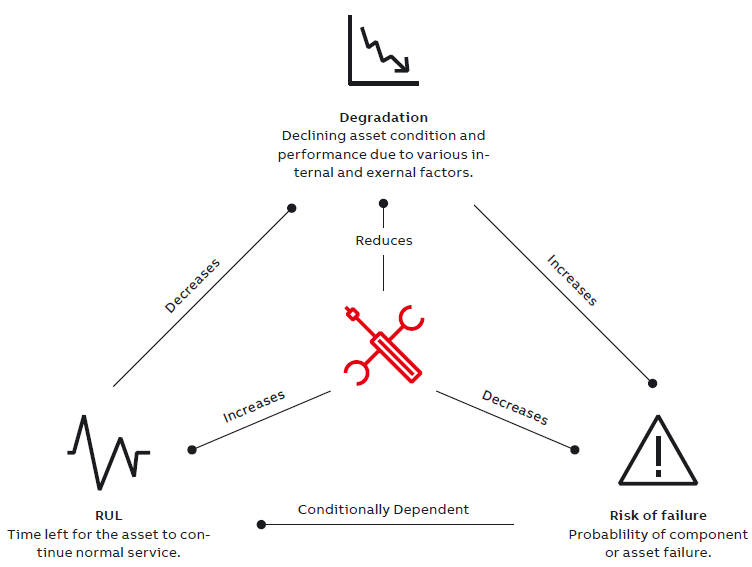

### We start by selecting a random generator and looking over its behaviour over time.

In [ ]:
plt.figure(figsize=(14,7))
plt.xlabel("DATE")
plt.ylabel("DC Power")
plt.title("1BY6WEcLGh8j5v7 over Days")
df=df_pgen1[df_pgen1['SOURCE_KEY']=='ZoEaEvLYb1n2sOq'][['DATE','DC_POWER',"AC_POWER"]]
df=df.groupby("DATE").sum()
sns.lineplot(data=df, palette="tab10", linewidth=2.5)
plt.show()

In [ ]:
df=df_pgen1[df_pgen1['DATE']=='2020-05-15	'][['DATE','DC_POWER',"AC_POWER","TIME"]]
a=[]
for t in df["TIME"]:
    a.append(t.strftime("%H:%M:%S"))

### Graphing DC and AC Power Generation to look fort peak Times

In [ ]:
fig = px.line(df, x=a, y=[df["DC_POWER"]])
fig.show()

In [ ]:
fig = px.line(df, x=a, y=[df["AC_POWER"]])
fig.show()

### Pairwise scatter plots between coefficient estimates suggesting collinearity between {temperature, precipitation} and humidity.

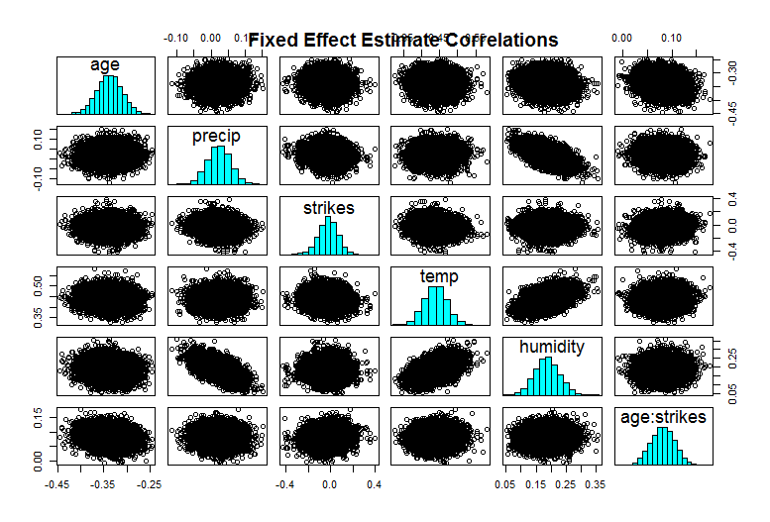

### Failure Ratios

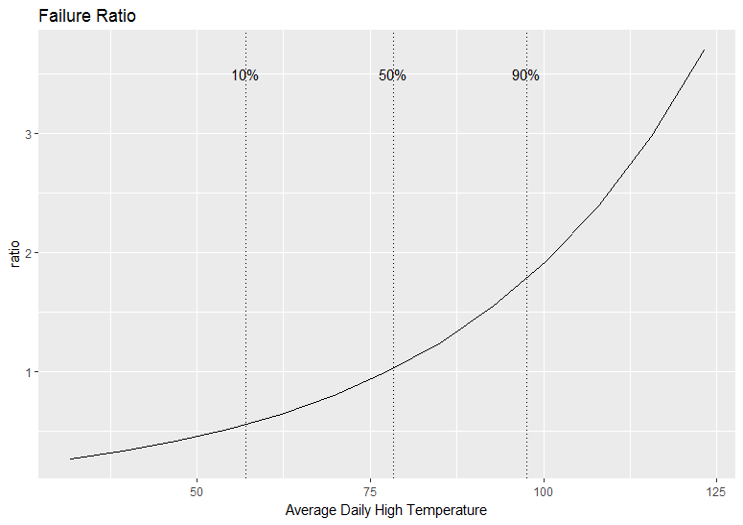

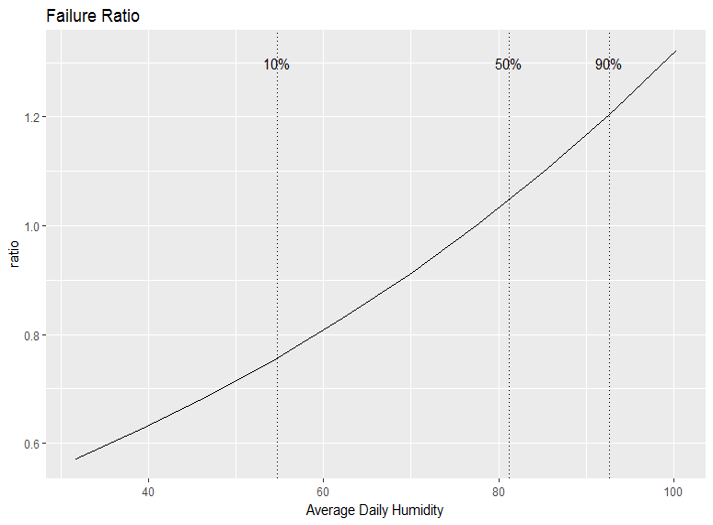

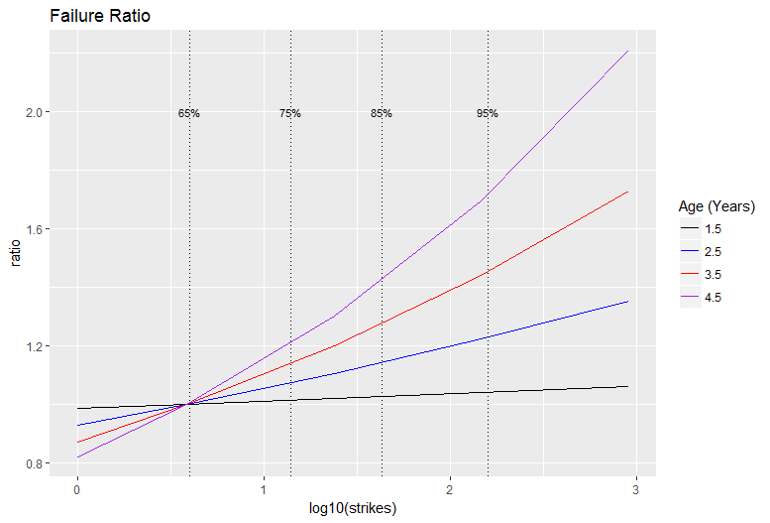

#### These graphs present some interesting ideas we wanted to explore, but couldn't due to lack of data.

# **Conclusion**

* ### Our goal for these studies was to explore how predictions of solar inverter and plant health and production can be improved by applying data science techniques
* ### These analytics enable detection of degradation and improvements in production of solar energy
* ### We can leverage Machine Learning and data science to better understand and classify potential root causes of device malfunction such as lightning, booster error, or grid inrush.

# **Business Value**

### Solar professionals are highly interested in minimizing Total Costs of Ownership (TCO). Inverter manufacturers can help meet their needs by offering analytics that provide early detection of degradation and early prediction of failure. These analytics can provide valuable lead time for performing maintenance and, if necessary, for acquiring and installing a replacement device or the right parts, to minimize maintenance costs and prevent days of lost solar energy production. Actual monetary benefits are situational and can be calculated based on factors such as days of lead time, whether hot spares are available, and avoidance of multiple service trips by bringing replacements for the most-likely components. Other factors include regulatory penalties and the value of electricity in the region.

# **Furthur Exploration**

* ### Estimation of power production, based on factors such as seasonality and current irradiance, may be used for detecting defects in the solar plant. Estimated DC or AC energy can be compared to the actual values measured by inverters during the same time period. Significant deviations or patterns may indicate possible defects in the solar plant (e.g., degradation or sudden failure in one or more pieces of equipment,from the panels to inverters).

* ### Forecasts of power production may be used to reduce inherent uncertainties associated with variable renewable energy generation. Grid operators today rely upon forecasts of both load and generation to balance electricity supply and demand. Accurate forecasts not only support the safe and reliable operation of the grid, but also encourage cost-effective operations by improving the scheduling of generation and reducing the use of costly ’spinning reserves’

* ### Since photovoltaic equipment (often including the inverter) is constantly exposed to atmospheric conditions, identifying relationships between weather exposure and device failure is a critical step in developing more resilient equipment and for understanding degradation, performance, or failures. For instance, field engineers servicing solar inverters have noted that device failures seem to occur more frequently after intense lightning storms